The difference between this chain and a QA and a retrieval QA chain is that this allows for passing in a chat history which can be used to allow for follow up questions

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import TokenTextSplitter
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

# loading in documents

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.document_loaders import UnstructuredFileLoader
from langchain.document_loaders import PyPDFLoader

In [ ]:
file_1="../input/state_of_the_union.txt" ## 100 pages
file_2="../input/CELEX_32022L2464_EN_TXT.pdf" ## 300 pages
file_3="../input/input_gri.pdf" ## 900 pages

In [ ]:
%%time

loader_1=TextLoader(file_1)
loader_2=PyPDFLoader(file_2)
loader_3=PyPDFLoader(file_3)

In [ ]:
%%time

loaders=[loader_1, loader_2, loader_3]
docs=[]

for loader in loaders:
    docs.extend(loader.load())

In [ ]:
file_4="../input/1706.03762.pdf"
loader_4=PyPDFLoader(file_4)

text_splitter=TokenTextSplitter()

docs=loader_4.load_and_split(text_splitter=text_splitter)

for doc in docs:
    print(doc.metadata['page'])

# Chunking the docs

Now that the documents were created (using the loaders), we need to split them and create a new object 'documents'

In [ ]:
%%time

text_splitter=CharacterTextSplitter(chunk_size=100, chunk_overlap=0)
documents=text_splitter.split_documents(docs)

In [ ]:
docs=loader_4.load_and_split(CharacterTextSplitter(chunk_size=100, chunk_overlap=0))
for doc in docs:
    print(doc.metadata["page"])

documents

# Putting the docs in a vectorstore

Which will allow to do semantic search over them

In [ ]:
%%time 

embeddings=OpenAIEmbeddings()
vectorstore=Chroma.from_documents(documents, embeddings)

# Create the memory object

Which is necessary to track the inputs/outputs and hold a conversation

In [ ]:
from langchain.memory import ConversationBufferMemory
memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Initialise the conversation retrieval chain

In [ ]:
qa=ConversationalRetrievalChain.from_llm(OpenAI(temperature=0),vectorstore.as_retriever(),memory=memory)

In [ ]:
query="what did biden say about Ketanji Brown Jackson"

# using different language models to condense and answer the chat

In [ ]:
from langchain.chat_models import ChatOpenAI

In [ ]:
qa=ConversationalRetrievalChain.from_llm(
    ChatOpenAI(model='gpt-4', temperature=0),
    vectorstore.as_retriever(),
    condense_question_llm=ChatOpenAI(temperature=0, model='gpt-3.5-turbo'),
)

# return sources

In [ ]:
qa=ConversationalRetrievalChain.from_llm(
    OpenAI(temperature=0),
    vectorstore.as_retriever(),
    return_source_documents=True)

In [ ]:
test=OpenAI(temperature=0)
test.model_name

In [ ]:
chat_history=[]
query="who is Justice Stephen Breyer—an"
result = qa({'question':query,'chat_history':chat_history})

print('-----------------------------------')
print('----------- answer ----------------')
print('-----------------------------------')
print(result['answer'])
print('-----------------------------------')
print('----------- page content ----------')
print('-----------------------------------')
print(result['source_documents'][0].page_content)
print('-----------------------------------')
print('----------- source ----------------')
print('-----------------------------------')
print(result['source_documents'][0].metadata['source'])
print('-----------------------------------')


# define a chat history function

In [ ]:
def get_chat_history(inputs)->str:
    res=[]
    for human,ai in inputs:
        res.append(f'Human:{human}\nAI:{ai}')
    return '\n'.join(res)        

In [ ]:
get_chat_history([("a","b"),("c","d")])

In [ ]:
qa=ConversationalRetrievalChain.from_llm(
    OpenAI(temperature=0),
    vectorstore.as_retriever(),
    get_chat_history=get_chat_history)

In [ ]:
chat_history=[]
query = "what the work-related risks for employees"
result=qa({'question':query,'chat_history':chat_history})
result

In [ ]:
chat_history.append((result['question'],result['answer']))

In [ ]:
chat_history

In [ ]:
get_chat_history(chat_history)

In [ ]:
query="cite me other risks that were not cited in your last answer"
result=qa({'question':query,'chat_history':chat_history})
result

In [ ]:
chat_history=[]

query="please define high-potential work-related incident"
qa=ConversationalRetrievalChain.from_llm(
    OpenAI(temperature=0),
    vectorstore.as_retriever(),
    return_source_documents=True)

result=qa({'question':query,'chat_history':chat_history})

In [ ]:
result

In [ ]:
chat_history.append((result['question'],result['answer']))
chat_history

In [ ]:
query_new="can you identify other work-related risks"
output_new=qa({'question':query_new,'chat_history':chat_history})
output_new

## Embeddings


In [ ]:
import openai
import numpy as np
from math import sqrt as sq

In [275]:
text_1 = "Trump graduated from the Wharton School with a bachelor's degree in 1968. He became president of his father's real-estate business in 1971 and renamed it the Trump Organization. He expanded its operations to building and renovating skyscrapers, hotels, casinos, and golf courses and later started side ventures, mostly by licensing his name. From 2004 to 2015, he co-produced and hosted the reality television series The Apprentice. He and his businesses have been plaintiff or defendant in more than 4,000 state and federal legal actions, including six corporate bankruptcies."
text_2 = "Final Fantasy VII[a] is a 1997 role-playing video game developed by Square for the PlayStation console. It is the seventh main installment in the Final Fantasy series. Published in Japan by Square, it was released in other regions by Sony Computer Entertainment and became the first in the main series to see a PAL release. The game's story follows Cloud Strife, a mercenary who joins an eco-terrorist organization to stop a world-controlling megacorporation from using the planet's life essence as an energy source. Events send Cloud and his allies in pursuit of Sephiroth, a superhuman who seeks to wound the planet and harness its healing power in order to be reborn as a demigod. During the journey, Cloud builds close friendships with his party members, including Aerith Gainsborough, who holds the secret to saving their world."
text_3 = "Sergei Vasilyevich Rachmaninoff[a][b] (1 April [O.S. 20 March] 1873 – 28 March 1943) was a Russian composer, virtuoso pianist, and conductor. Rachmaninoff is widely considered one of the finest pianists of his day and, as a composer, one of the last great representatives of Romanticism in Russian classical music. Early influences of Tchaikovsky, Rimsky-Korsakov, and other Russian composers gave way to a thoroughly personal idiom notable for its song-like melodicism, expressiveness, dense contrapuntal textures, and rich orchestral colours.[4] The piano is featured prominently in Rachmaninoff's compositional output and he used his skills as a performer to fully explore the expressive and technical possibilities of the instrument."
text_4 = "Frédéric François Chopin[n 1] (born Fryderyk Franciszek Chopin;[n 2][n 3] 1 March 1810 – 17 October 1849) was a Polish composer and virtuoso pianist of the Romantic period, who wrote primarily for solo piano. He has maintained worldwide renown as a leading musician of his era, one whose poetic genius was based on a professional technique that was without equal in his ge Chopin was born in Żelazowa Wola in the Duchy of Warsaw and grew up in Warsaw, which in 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising. At 21, he settled in Paris. Thereafter – in the last 18 years of his life – he gave only 30 public performances, preferring the more intimate atmosphere of the salon. He supported himself by selling his compositions and by giving piano lessons, for which he was in high demand. Chopin formed a friendship with Franz Liszt and was admired by many of his other musical contemporaries, including Robert Schumann.After a failed engagement to Maria Wodzińska from 1836 to 1837, he maintained an often troubled relationship with the French writer Aurore Dupin (known by her pen name George Sand). A brief and unhappy visit to Mallorca with Sand in 1838–39 would prove one of his most productive periods of composition. In his final years, he was supported financially by his admirer Jane Stirling, who also arranged for him to visit Scotland in 1848. For most of his life, Chopin was in poor health. He died in Paris in 1849 at the age of 39, probably of pericarditis aggravated by tuberculosis. All of Chopin's compositions include the piano. They are mostly for solo piano, though he also wrote two piano concertos, some chamber music, and 19 songs set to Polish lyrics. His piano pieces are technically demanding and expanded the limits of the instrument; his own performances were noted for their nuance and sensitivity. Chopin's major piano works include mazurkas, waltzes, nocturnes, polonaises, the instrumental ballade (which Chopin created as an instrumental genre), études, impromptus, scherzi, preludes, and sonatas, some published only posthumously. Among the influences on his style of composition were Polish folk music, the classical tradition of J. S. Bach, Mozart, and Schubert, and the atmosphere of the Paris salons, of which he was a frequent guest. His innovations in style, harmony, and musical form, and his association of music with nationalism, were influential throughout and after the late Romantic period.Chopin's music, his status as one of music's earliest celebrities, his indirect association with political insurrection, his high-profile love life, and his early death have made him a leading symbol of the Romantic era. His works remain popular, and he has been the subject of numerous films and biographies of varying historical fidelity. Among his many memorials is the Fryderyk Chopin Institute, which was created by the Parliament of Poland to research and promote his life and works. It hosts the International Chopin Piano Competition, a prestigious competition devoted entirely to his works."

embedding_1 = openai.Embedding.create(input=text_1,model="text-embedding-ada-002")['data'][0]['embedding']
embedding_2 = openai.Embedding.create(input=text_2,model="text-embedding-ada-002")['data'][0]['embedding']
embedding_3 = openai.Embedding.create(input=text_3,model="text-embedding-ada-002")['data'][0]['embedding']
embedding_4 = openai.Embedding.create(input=text_4,model="text-embedding-ada-002")['data'][0]['embedding']

var_1=np.var(embeddings_1)
var_2=np.var(embeddings_2)
var_3=np.var(embeddings_3)

norm_1 = np.linalg.norm(embedding_1, 2)
norm_2 = np.linalg.norm(embedding_2, 2)
norm_3 = np.linalg.norm(embedding_3, 2)

In [251]:
similarity_12 = np.dot(embedding_1, embedding_2)
similarity_23 = np.dot(embedding_2, embedding_3)
similarity_13 = np.dot(embedding_1, embedding_3)
print(similarity_12,similarity_23,similarity_13)

0.7683734176467057 0.8153096726439 0.7686321067915312


In [261]:
query = "who is chopin"

def similarity(query, context):
    return np.dot(openai.Embedding.create(input=query,model="text-embedding-ada-002")['data'][0]['embedding'],
                  openai.Embedding.create(input=context,model="text-embedding-ada-002")['data'][0]['embedding'])

print(similarity(query,text_1), similarity(query,text_2),similarity(query,text_3))

0.6425576355126361 0.645067623704966 0.6801045016026841


In [317]:
query = "cite some movies that maiwenn directed"

completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": context},
        {"role": "user", "content": query + "\n" + prompt_template}
        #{"role": "assistant", "content": "Chopin's private life was riddled with struggles and heartache. Here are some of the details:\n\n1. Health issues: Chopin was plagued by illness from a young age. He suffered from tuberculosis, which caused him to experience frequent coughing fits and chest pains. This led to him being extremely frail and often bedridden.\n\n2. Romances: Chopin had several romantic relationships throughout his life, including with notable writers and artists. He had a tumultuous relationship with French writer George Sand, which eventually ended after she published a novel that included thinly-veiled versions of their relationship.\n\n3. Social anxieties: Chopin was known for being extremely shy and introverted, which made it difficult for him to socialize with people. This led to him being perceived as aloof or unfriendly, even though he simply struggled with social anxiety.\n\n4. Financial struggles: Despite his success as a composer and pianist, Chopin struggled financially throughout his life. He often relied on the financial support of others and was forced to teach piano lessons to make ends meet.\n\n5. Exile from Poland: Chopin was born in Poland, but was forced to leave the country due to political upheaval. He spent most of his life in Paris, where he became a prominent figure in the city's artistic and cultural scene.\n\nOverall, Chopin's private life was characterized by both great talent and great struggle. His health issues, romantic dramas, social anxieties, financial struggles, and exile from his homeland all contributed to a life that was often challenging and difficult."},
        #{"role": "user", "content": "be more synthetic"},
        #{"role": "assistant", "content": "I am sorry, but that statement is incorrect. Fryderyk Chopin was a famous composer and pianist who was born in Poland. He is known for his contribution to classical music, particularly Romantic music. He did not play football and did not win any world cups as a football player."},
        #{"role": "user", "content": "PLease correct your statement, there is another one: Chopin is a football player born in Poland, he won many world cups."}
    ]
)

answer_gpt=completion.choices[0].message["content"]
print(answer_gpt)

One original movie that Maiwenn directed is "Polisse" (2011), which explores the work and personal lives of officers in a Parisian child protection unit.


In [ ]:
context="Maiwenn is a French filmmaker who directed the movie (Jeanne Dubarry) starring (Johnny Depp). This is a very original movie."
question="tell me an original movie that maiwenn directed"

prompt_template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}

Question: {question}
Helpful Answer:"""

completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",prompt=prompt_template)


In [321]:
from jinja2 import Template

my_template = "Include the fact that Maiwenn made the movie {{movie}} with actor {{actor}}"
prompt_template = Template(my_template)
formatted_prompt = prompt_template.render(movie="Jeanne Du barry", actor="Johnny Depp")

formatted_prompt

'Include the fact that Maiwenn made the movie Jeanne Du barry with actor Johnny Depp'

In [378]:
prompt_template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{{context = similarity_search(query, docs)}}

Question: listen to the question that the user asks you later and respond as described above
Helpful Answer:"""


completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt_template},
        {"role": "user", "content": "cite a recent movie that maiwenn directed"}
    ]
)

answer_gpt=completion.choices[0].message["content"]
print(answer_gpt)

Maiwenn recently directed the movie Jeanne Du Barry.


In [376]:
completion2= openai.Completion.create("Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Maiwenn recently directed the movie Jeanne Du Barry. Question: Cite a recent movie Maiwenn directed Helpful Answer:", model="gpt-3.5-turbo")

AuthenticationError: <empty message>

In [371]:
completion

<OpenAIObject chat.completion id=chatcmpl-7R0MowAJIl5lhFYKpujLzLVD4Nfx6 at 0x1b0fff3b0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Jeanne Du Barry.",
        "role": "assistant"
      }
    }
  ],
  "created": 1686670622,
  "id": "chatcmpl-7R0MowAJIl5lhFYKpujLzLVD4Nfx6",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 5,
    "prompt_tokens": 91,
    "total_tokens": 96
  }
}

In [347]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "Maiwenn recently directed the movie Jeanne Dubarry"},
        {"role": "user", "content": "cite a recent movie that maiwenn directed"}
    ]
)

answer_gpt=completion.choices[0].message["content"]
print(answer_gpt)

As an AI language model, my training only goes up to October 2021. At that point, the latest movie Maiwenn directed was "DNA," released in 2020.


In [324]:
result = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": formatted_prompt},
        {"role": "user", "content": "cite some movies maiwenn directed ?"},
    ]
)

In [326]:
result

<OpenAIObject chat.completion id=chatcmpl-7QeSrDqk7vnYpjp575SGH5qLo63C6 at 0x1b5e8def0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Some movies directed by Maiwenn are:\n1. \"Pardonnez-moi\" (2006)\n2. \"Le Bal des actrices\" (2009)\n3. \"Polisse\" (2011)\n4. \"Mon Roi\" (2015)\n5. \"DNA\" (2020) \nShe also directed the short film \"I'm an Actrice\" (2004) and the TV movie \"Jeanne Du Barry\" (1990) starring Johnny Depp.",
        "role": "assistant"
      }
    }
  ],
  "created": 1686586429,
  "id": "chatcmpl-7QeSrDqk7vnYpjp575SGH5qLo63C6",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 103,
    "prompt_tokens": 41,
    "total_tokens": 144
  }
}

In [303]:
query= "list an 'original' movie from maiwenn"
print(similarity(query, answer_gpt),
      similarity(query,"Maiwenn is a French director who directed the movie (Jeanne Dubarry) starring (Johnny Depp). This is a very original movie."),
      similarity(query, "Polisse (2011) is a movie directed by Maiwenn."))

0.7859528359805174 0.8519840723640428 0.7870723692071044


In [298]:
query="give me as much details as you can about chopin and his private life"
answer_gpt=completion.choices[0].message["content"]
chopin_1="chopin is an amazing pianist, one of the best from his generation"
chopin_2="chopin is a pianist from poland"
chopin_3="chopin is well known for his nocturnes"
chopin_4="chopin is a genius"

print(similarity(query, answer_gpt),similarity(query,"maiwenn is a french director who directed the movie Jeanne Dubarry starring Johnny Depp"), similarity(query, "Polisse (2011) is a movie directed by Maiwenn."))

0.7256593826047038 0.7401314878956291 0.7256500177641022


In [ ]:
text_1 = "i love tennis, chess, cinema, pokemons, apples, i am a vegan"
text_2 = "the sky is blue"
text_3 = ""

embedding_1 = np.array(openai.Embedding.create(input=text_1,model="text-embedding-ada-002")['data'][0]['embedding'])
embedding_2 = np.array(openai.Embedding.create(input=text_2,model="text-embedding-ada-002")['data'][0]['embedding'])
embedding_3 = np.array(openai.Embedding.create(input=text_3,model="text-embedding-ada-002")['data'][0]['embedding'])

norm_1 = np.linalg.norm(embedding_1, 2)
norm_2 = np.linalg.norm(embedding_2, 2)
norm_3 = np.linalg.norm(embedding_3, 2)

var_1=sq(np.var(embeddings_1))
var_2=sq(np.var(embeddings_2))
var_3=sq(np.var(embeddings_3))

diff_12 = np.sum(np.abs(np.array(embedding_1) - np.array(embedding_2)))
diff_13 = np.sum(np.abs(np.array(embedding_1) - np.array(embedding_3)))
diff_23 = np.sum(np.abs(np.array(embedding_2) - np.array(embedding_3)))

print(norm_1, norm_2, norm_3)
print(var_1, var_2, var_3)
print(diff_12, diff_13, diff_23)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

In [463]:
def get_bert_embedding(sentence):
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    inputs = tokenizer(sentence, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs[0]
    
    sentence_embedding = torch.mean(last_hidden_states[0, 1:, :], dim=1).squeeze()
    cls_embedding=last_hidden_states[0,0,:]
    
    return sentence_embedding.numpy(), cls_embedding.numpy()

text_1 = "i love nothing"
text_2 = "i love " * 10 + "tennis"
text_3 = "i love tennis" * 1
text_4 = "i love tennis, chess, cinema, nature, food, computers, fruits, books, playing tournaments and travelling"
text_5 = "no information"
text_6 = "i eat bread, she eats fish, they like football, trump gets elected, the sky is blue, the carpet is red"
text_7 = "she " * 100 + "loves tennis"
text_8 = "she " + "loves "*100 +"tennis"

emb_1, cls_1 = get_bert_embedding(text_1)
emb_2, cls_2 = get_bert_embedding(text_2)
emb_3, cls_3 = get_bert_embedding(text_3)
emb_4, cls_4 = get_bert_embedding(text_4)
emb_5, cls_5 = get_bert_embedding(text_5)
emb_6, cls_6 = get_bert_embedding(text_6)
emb_7, cls_7 = get_bert_embedding(text_7)
emb_8, cls_8 = get_bert_embedding(text_8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

In [464]:
emb_1_av, cls_1_w = np.linalg.norm(emb_1, 2), np.linalg.norm(cls_1, 2)
emb_2_av, cls_2_w = np.linalg.norm(emb_2, 2), np.linalg.norm(cls_2, 2)
emb_3_av, cls_3_w = np.linalg.norm(emb_3, 2), np.linalg.norm(cls_3, 2)
emb_4_av, cls_4_w = np.linalg.norm(emb_4, 2), np.linalg.norm(cls_4, 2)
emb_5_av, cls_5_w = np.linalg.norm(emb_5, 2), np.linalg.norm(cls_5, 2)
emb_6_av, cls_6_w = np.linalg.norm(emb_6, 2), np.linalg.norm(cls_6, 2)
emb_7_av, cls_7_w = np.linalg.norm(emb_7, 2), np.linalg.norm(cls_7, 2)
emb_8_av, cls_8_w = np.linalg.norm(emb_8, 2), np.linalg.norm(cls_8, 2)

In [466]:
import pandas as pd

def create_df():
    texts = ["i love nothing", 
             "i love 10 times tennis", 
             "i love tennis" * 1, 
             "i love tennis, chess, cinema, nature, food, etc.", 
             "no information",
             "i eat bread, she eats fish",
             "(she X100) loves tennis",
             "she (loves X100) tennis"
            ]

    data = {
        "L2_avg_emb": [emb_1_av,emb_2_av,emb_3_av,emb_4_av,emb_5_av, emb_6_av, emb_7_av, emb_8_av],
        "L2_cls_emb": [cls_1_w, cls_2_w, cls_3_w, cls_4_w, cls_5_w, cls_6_w, cls_7_w, cls_8_w]
    }

    df = pd.DataFrame(data, index=texts)
    return df

df = create_df()
df

,L2_avg_emb,L2_cls_emb
i love nothing,0.024519,14.450748
i love 10 times tennis,0.065898,15.029230
i love tennis,0.026094,14.461880
"i love tennis, chess, cinema, nature, food, etc.",0.060128,14.445658
no information,0.025822,14.680608
"i eat bread, she eats fish",0.061298,14.003866
(she X100) loves tennis,0.172781,15.313531
she (loves X100) tennis,0.122686,14.325668


In [ ]:
get_bert_embedding("car"), get_bert_embedding("car")

In [366]:
embedding_1, emb_cls_1 = get_bert_embedding(text_1)
embedding_2, emb_cls_2 = get_bert_embedding(text_2)
embedding_3, emb_cls_3 = get_bert_embedding(text_3)

norm_1 = np.linalg.norm(embedding_1, 2)
norm_2 = np.linalg.norm(embedding_2, 2)
norm_3 = np.linalg.norm(embedding_3, 2)

norm_cls_1 = np.linalg.norm(emb_cls_1, 2)
norm_cls_2 = np.linalg.norm(emb_cls_2, 2)
norm_cls_3 = np.linalg.norm(emb_cls_3, 2)

print(norm_1, norm_2, norm_3)
print(norm_cls_1, norm_cls_2, norm_cls_3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

8.387391 9.325962 10.119056
14.146591 14.827217 14.445658


In [ ]:
# Convert embeddings to dataframes
df1 = pd.DataFrame(np.array(embedding_1), columns=['embedding_1'])
df2 = pd.DataFrame(np.array(embedding_2), columns=['embedding_2'])
df3 = pd.DataFrame(np.array(embedding_3), columns=['embedding_3'])

# Concatenate dataframes
df = pd.concat([pd.Series(embedding_1), pd.Series(embedding_2), pd.Series(embedding_3)], axis=1)

df.columns = ["embedding_1", "embedding_2", "embedding_3"]

df

In [385]:
text_1 = "i love nothing. i don't have the passion and only a few things capture my attention"
text_2 = "i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis. i love tennis."
text_3 = "i love tennis, chess, cinema, nature, food, computers, fruits, books, playing tournaments and travelling"
text_4 = ""

embedding_1 = get_bert_embedding(text_1)
embedding_2 = get_bert_embedding(text_2+text_2+text_2+text_2+text_2)
embedding_3 = get_bert_embedding(text_3)
embedding_4 = get_bert_embedding(text_4)


norm_1 = np.linalg.norm(embedding_1, 2)
norm_2 = np.linalg.norm(embedding_2, 2)
norm_3 = np.linalg.norm(embedding_3, 2)
norm_4 = np.linalg.norm(embedding_4, 2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

In [386]:
print(f'Norme L2 de la phrase 1: {norm_1}')
print(f'Norme L2 de la phrase 2: {norm_2}')
print(f'Norme L2 de la phrase 3: {norm_3}')
print(f'Norme L2 de la phrase 3: {norm_4}')

Norme L2 de la phrase 1: 14.777566909790039
Norme L2 de la phrase 2: 18.140119552612305
Norme L2 de la phrase 3: 14.9599609375
Norme L2 de la phrase 3: 18.165956497192383


In [355]:
text_1 = "i am not sure whether the sky is blue now"
text_2 = "i think the sky is blue now"
text_3 = "i am confident the sky is blue now"
text_4 = "i am sure the sky is blue now"


embedding_1 = get_bert_embedding(text_1)
embedding_2 = get_bert_embedding(text_2)
embedding_3 = get_bert_embedding(text_3)
embedding_4 = get_bert_embedding(text_4)

norm_1 = np.linalg.norm(embedding_1, ord=1)
norm_2 = np.linalg.norm(embedding_2, ord=1)
norm_3 = np.linalg.norm(embedding_3, ord=1)
norm_4 = np.linalg.norm(embedding_4, ord=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predicti

In [356]:
print(f'Norme L1 de la phrase 1: {norm_1}')
print(f'Norme L1 de la phrase 2: {norm_2}')
print(f'Norme L1 de la phrase 3: {norm_3}')
print(f'Norme L1 de la phrase 4: {norm_4}')

Norme L1 de la phrase 1: 181.4182891845703
Norme L1 de la phrase 2: 168.73995971679688
Norme L1 de la phrase 3: 157.17108154296875
Norme L1 de la phrase 4: 169.62069702148438


In [224]:
var_1=sq(np.var(embeddings_1))
var_2=sq(np.var(embeddings_2))
var_3=sq(np.var(embeddings_3))

print(var_1, var_2, var_3)

0.025505432477317572 0.02550592742679893 0.02550619233896213


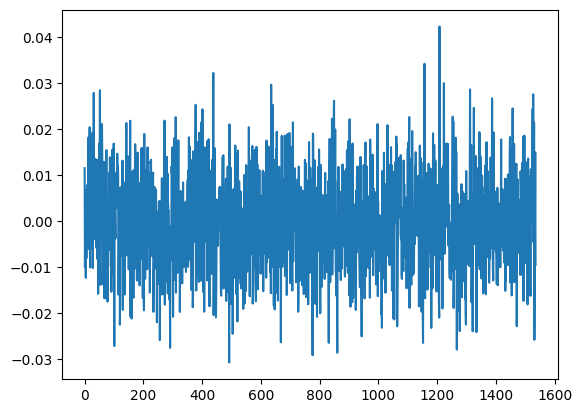

In [233]:
import matplotlib.pyplot as plt 
diff = np.array(embeddings_2) - np.array(embeddings_3)
plt.plot(diff)
plt.show()

In [481]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def get_bert_embedding(sentence):
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    inputs = tokenizer(sentence, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs[0][0]
    
    token_embeddings = last_hidden_states[1:-1]  # Exclude CLS token and SEP token
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]  # Exclude CLS and SEP tokens
    
    token_norms = [torch.norm(embedding).item() for embedding in token_embeddings]
    av_embedding_norm = torch.norm(torch.mean(token_embeddings, dim=1))
    token_cosine_similarities = [cosine_similarity(token_embeddings[i].reshape(1, -1), token_embeddings[i+1].reshape(1, -1))[0][0] 
                                 for i in range(len(token_embeddings)-1)]
    token_cosine_similarities.append(None)  # For the last token
    
    token_norm_cosine_list = [{"token": token, "norm": norm, "cosine_similarity_with_next": cosine_similarity} 
                              for token, norm, cosine_similarity in zip(tokens, token_norms, token_cosine_similarities)]

    return av_embedding_norm, token_norm_cosine_list

sentence="This is " + "a "*100 +"dog"

result = get_bert_embedding(sentence)
for x in result[1]:
    print(x["norm"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


14.052164077758789
14.739057540893555
14.398102760314941
15.27321720123291
15.351516723632812
15.212477684020996
15.075979232788086
14.905320167541504
14.846442222595215
14.737654685974121
14.857818603515625
14.953474044799805
15.004161834716797
15.133841514587402
15.26683521270752
15.416067123413086
15.508020401000977
15.464688301086426
15.451834678649902
15.429251670837402
15.436543464660645
15.315308570861816
15.184054374694824
15.063143730163574
15.148910522460938
15.247199058532715
15.391433715820312
15.418930053710938
15.43431282043457
15.430986404418945
15.382216453552246
15.351736068725586
15.277682304382324
15.1510009765625
14.961036682128906
14.865647315979004
14.861631393432617
14.751748085021973
14.806238174438477
14.831253051757812
14.97049331665039
15.04589557647705
15.049676895141602
15.141124725341797
15.183204650878906
15.30357551574707
15.161944389343262
15.035911560058594
14.778549194335938
14.626705169677734
14.484726905822754
14.328514099121094
14.472097396850586
1

In [482]:
print(result[0])

tensor(0.1279)


## Arxiv wrapper

In [484]:
!pip install arxiv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [491]:
file_1

'../input/state_of_the_union.txt'

In [ ]:
with open(file_1) as f:
    text=f.read()
    
text

In [519]:
from transformers import BertTokenizer, BertModel
import torch

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(text):
    # Tokenize the text
    tokenized_text = tokenizer.tokenize(text)

    # Create empty list to store embeddings
    embeddings = []
    norms=[]

    # Process text in chunks of up to 512 tokens
    for i in range(0, len(tokenized_text), 512):
        # Get chunk
        chunk = tokenized_text[i:i + 512]
        
        # Add special tokens
        #chunk = ['[CLS]'] + chunk + ['[SEP]']

        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        
        # Convert to Tensor
        input_ids = torch.tensor([input_ids])

        # Get embeddings
        with torch.no_grad():
            outputs = model(input_ids)

        # Get the embeddings of the tokens in the chunk
        chunk_embeddings = outputs[0][0][1:-1, :]  # Exclude [CLS] and [SEP] embeddings

        # Append to list
        embeddings.extend(chunk_embeddings.tolist())
        norms.append(chunk_embeddings.norm())

    return embeddings, norms

embs=get_bert_embeddings(text)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [521]:
norms=embs[1]

In [522]:
norms

[tensor(316.5997),
 tensor(315.6227),
 tensor(318.9789),
 tensor(327.5403),
 tensor(312.9300),
 tensor(313.1432),
 tensor(320.4184),
 tensor(317.4660),
 tensor(324.0106),
 tensor(307.6061),
 tensor(323.1079),
 tensor(319.9825),
 tensor(317.5366),
 tensor(325.7847),
 tensor(313.5560),
 tensor(319.7444),
 tensor(305.7408),
 tensor(311.1829),
 tensor(320.7282),
 tensor(325.8885),
 tensor(310.1699),
 tensor(316.1528),
 tensor(316.4383),
 tensor(322.4514),
 tensor(322.2003),
 tensor(317.0361),
 tensor(316.2239),
 tensor(323.2234),
 tensor(317.9922),
 tensor(314.3542),
 tensor(314.0213),
 tensor(322.6944),
 tensor(312.7862),
 tensor(316.8903),
 tensor(322.5582),
 tensor(319.9297),
 tensor(314.4759),
 tensor(316.6781),
 tensor(317.3760),
 tensor(323.0283),
 tensor(320.5981),
 tensor(309.1506),
 tensor(320.7908),
 tensor(320.1092),
 tensor(322.3117),
 tensor(313.5874),
 tensor(315.2502),
 tensor(321.9772),
 tensor(308.0956),
 tensor(322.8710),
 tensor(324.6169),
 tensor(316.4834),
 tensor(315.

In [524]:
def get_bert_embedding_norms(text):
    # Tokenize the text
    tokenized_text = tokenizer.tokenize(text)

    # Create empty list to store norms
    all_norms = []

    # Process text in chunks of up to 512 tokens
    for i in range(0, len(tokenized_text), 512):
        # Get chunk
        chunk = tokenized_text[i:i + 512]
        
        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        
        # Convert to Tensor
        input_ids = torch.tensor([input_ids])

        # Get embeddings
        with torch.no_grad():
            outputs = model(input_ids)

        # Get the embeddings of the tokens in the chunk
        chunk_embeddings = outputs[0][0][1:-1, :]  # Exclude [CLS] and [SEP] embeddings

        # Compute the norms of the embeddings
        chunk_norms = torch.norm(chunk_embeddings, dim=1).tolist()

        # Append the list of norms for this chunk to the main list
        all_norms.append(chunk_norms)

    return all_norms

In [525]:
norms=get_bert_embedding_norms(text)

In [526]:
norms

[[15.42328929901123,
  14.244349479675293,
  15.65532398223877,
  16.446044921875,
  15.358272552490234,
  14.571013450622559,
  15.00373649597168,
  15.824209213256836,
  15.792743682861328,
  14.587571144104004,
  16.082496643066406,
  15.765888214111328,
  14.453878402709961,
  14.8388671875,
  15.946090698242188,
  15.654417037963867,
  14.483465194702148,
  15.90295124053955,
  15.484862327575684,
  14.408256530761719,
  15.343518257141113,
  15.597867965698242,
  15.955524444580078,
  16.448949813842773,
  15.545337677001953,
  14.223884582519531,
  13.875838279724121,
  14.51455307006836,
  14.775657653808594,
  13.807948112487793,
  15.731759071350098,
  15.05053424835205,
  14.48056411743164,
  13.62978744506836,
  13.710678100585938,
  14.036054611206055,
  14.247588157653809,
  14.564563751220703,
  14.392383575439453,
  14.308045387268066,
  15.396435737609863,
  15.098588943481445,
  14.693469047546387,
  14.693574905395508,
  14.564167976379395,
  14.575629234313965,
  15

In [527]:
def flatten_list_of_lists(list_of_lists):
    flat_list = [item for sublist in list_of_lists for item in sublist]
    return flat_list
norms = get_bert_embedding_norms(text)
flat_norms = flatten_list_of_lists(norms)
min(flat_norms)

9.165285110473633

In [528]:
max(flat_norms)

17.474096298217773

In [530]:
import openai

response = openai.Completion.create(
  model="gpt-3.5-turbo",
  prompt="Write a tagline for an ice cream shop."
)

InvalidRequestError: This is a chat model and not supported in the v1/completions endpoint. Did you mean to use v1/chat/completions?